In [1]:
from _utils import *
from scipy.stats import qmc
import kmedoids
from sklearn.metrics.pairwise import euclidean_distances

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

def calculate_distance_map(polys):
    # Extract the dimensions of the input array
    num_probes, num_coords, num_cells = polys.shape
    
    # Initialize an array of the same shape to hold the interpolated values
    new_maps = np.zeros((num_cells, num_probes, num_probes))
    
    # Iterate over each cell
    for c in range(num_cells):
        # Extract the data for the current cell
        curr_cells = polys[:, :, c]
        
        # Skip cells with all missing values
        if np.all(np.isnan(curr_cells)):
            continue  # This leaves a matrix of zeros in the output array
        
        # Calculate the pairwise Euclidean distance between each pair of probes
        dmap = squareform(pdist(curr_cells))
        
        # Assign the distance map to the corresponding position in the output array
        new_maps[c, :, :] = dmap
    
    # Return the array with interpolated values
    return new_maps

esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

2024-10-16 13:00:40.735025: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 13:00:41.235059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [116]:
mcmc_common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results'

# Find all the folders in the MCMC result directory with 'Kmedoid' in the name
mcmc_folders = [f for f in os.listdir(mcmc_common_dir) if 'Kmedoid' in f]

# Get the full path to each of the folders
mcmc_folders = [os.path.join(mcmc_common_dir, f) for f in mcmc_folders]

# Sort based on the number in the filename 
# Number is in the last part after the last underscore
mcmc_folders.sort(key=lambda x: int(x.split('_')[-1]))

# Extract the number of clusters from the folder names
num_clusters = [int(f.split('_')[-1]) for f in mcmc_folders]

In [117]:
mcmc_folders

['/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_Kmedoid_10',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_Kmedoid_20',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_Kmedoid_30',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_Kmedoid_40',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_Kmedoid_50',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_Kmedoid_75',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightM

In [86]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20241016'

In [110]:
def load_mcmc_results(mcmc_path, num_microstates):
    # Find stan_output folder path and then load the MCMC samples
    # List all items in the current directory
    mcmc_result = {}
    for item in tqdm(os.listdir(mcmc_path)):
        # Get the full path of the item
        full_path = os.path.join(mcmc_path, item)
        
        # Check if the item is a directory
        # And if the directory contains stan_output folder
        # Check if 'stan_output' exists in the directory
        folder_path = os.path.join(full_path, 'stan_output')
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            # Load the MCMC results
            mcmc_result[item] = load_weights(folder_path, num_microstates)
            
    return mcmc_result

In [118]:
mcmc_results = []
for i, k in enumerate(num_clusters):
    mcmc_results.append(load_mcmc_results(mcmc_folders[i], k))

  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015143708_1.csv', '20240715_WeightOptimization-20241015143708_2.csv', '20240715_WeightOptimization-20241015143708_3.csv', '20240715_WeightOptimization-20241015143708_4.csv']
['20240715_WeightOptimization-20241015143708_1.csv', '20240715_WeightOptimization-20241015143708_2.csv', '20240715_WeightOptimization-20241015143708_3.csv', '20240715_WeightOptimization-20241015143708_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015143837_1.csv', '20240715_WeightOptimization-20241015143837_2.csv', '20240715_WeightOptimization-20241015143837_3.csv', '20240715_WeightOptimization-20241015143837_4.csv']
['20240715_WeightOptimization-20241015143853_1.csv', '20240715_WeightOptimization-20241015143853_2.csv', '20240715_WeightOptimization-20241015143853_3.csv', '20240715_WeightOptimization-20241015143853_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015144032_1.csv', '20240715_WeightOptimization-20241015144032_2.csv', '20240715_WeightOptimization-20241015144032_3.csv', '20240715_WeightOptimization-20241015144032_4.csv']
['20240715_WeightOptimization-20241015144033_1.csv', '20240715_WeightOptimization-20241015144033_2.csv', '20240715_WeightOptimization-20241015144033_3.csv', '20240715_WeightOptimization-20241015144033_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015144222_1.csv', '20240715_WeightOptimization-20241015144222_2.csv', '20240715_WeightOptimization-20241015144222_3.csv', '20240715_WeightOptimization-20241015144222_4.csv']
['20240715_WeightOptimization-20241015144244_1.csv', '20240715_WeightOptimization-20241015144244_2.csv', '20240715_WeightOptimization-20241015144244_3.csv', '20240715_WeightOptimization-20241015144244_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241015144422_1.csv', '20240715_WeightOptimization-20241015144422_2.csv', '20240715_WeightOptimization-20241015144422_3.csv', '20240715_WeightOptimization-20241015144422_4.csv']
['20240715_WeightOptimization-20241015144437_1.csv', '20240715_WeightOptimization-20241015144437_2.csv', '20240715_WeightOptimization-20241015144437_3.csv', '20240715_WeightOptimization-20241015144437_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241016203120_1.csv', '20240715_WeightOptimization-20241016203120_2.csv', '20240715_WeightOptimization-20241016203120_3.csv', '20240715_WeightOptimization-20241016203120_4.csv']
['20240715_WeightOptimization-20241016203120_1.csv', '20240715_WeightOptimization-20241016203120_2.csv', '20240715_WeightOptimization-20241016203120_3.csv', '20240715_WeightOptimization-20241016203120_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241016203305_1.csv', '20240715_WeightOptimization-20241016203305_2.csv', '20240715_WeightOptimization-20241016203305_3.csv', '20240715_WeightOptimization-20241016203305_4.csv']
['20240715_WeightOptimization-20241016203315_1.csv', '20240715_WeightOptimization-20241016203315_2.csv', '20240715_WeightOptimization-20241016203315_3.csv', '20240715_WeightOptimization-20241016203315_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241016203614_1.csv', '20240715_WeightOptimization-20241016203614_2.csv', '20240715_WeightOptimization-20241016203614_3.csv', '20240715_WeightOptimization-20241016203614_4.csv']
['20240715_WeightOptimization-20241016203606_1.csv', '20240715_WeightOptimization-20241016203606_2.csv', '20240715_WeightOptimization-20241016203606_3.csv', '20240715_WeightOptimization-20241016203606_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241016203908_1.csv', '20240715_WeightOptimization-20241016203908_2.csv', '20240715_WeightOptimization-20241016203908_3.csv', '20240715_WeightOptimization-20241016203908_4.csv']
['20240715_WeightOptimization-20241016203908_1.csv', '20240715_WeightOptimization-20241016203908_2.csv', '20240715_WeightOptimization-20241016203908_3.csv', '20240715_WeightOptimization-20241016203908_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241016204312_1.csv', '20240715_WeightOptimization-20241016204312_2.csv', '20240715_WeightOptimization-20241016204312_3.csv', '20240715_WeightOptimization-20241016204312_4.csv']
['20240715_WeightOptimization-20241016204312_1.csv', '20240715_WeightOptimization-20241016204312_2.csv', '20240715_WeightOptimization-20241016204312_3.csv', '20240715_WeightOptimization-20241016204312_4.csv']


In [28]:
def calculate_entropy(mcmc_sample):
    return np.array([scipy.stats.entropy(x) for x in mcmc_sample])

In [119]:
mcmc_weights_esc = []
mcmc_weights_cnc = []

entropy_dfs = []

for i, k in enumerate(num_clusters):
    curr_sample = mcmc_results[i]
    curr_sample_esc = curr_sample['ESC']
    curr_sample_cnc = curr_sample['CNC']
    
    esc_weights = np.exp(np.array(curr_sample_esc))
    cnc_weights = np.exp(np.array(curr_sample_cnc))
    
    esc_weights = esc_weights.reshape(-1, k)
    cnc_weights = cnc_weights.reshape(-1, k)
    
    mcmc_weights_esc.append(esc_weights)
    mcmc_weights_cnc.append(cnc_weights)
    
    esc_entropy_all = calculate_entropy(esc_weights)
    cnc_entropy_all = calculate_entropy(cnc_weights)
    
    esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
    cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'CNC'})
    
    entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df])
    entropy_dfs.append(entropy_df)

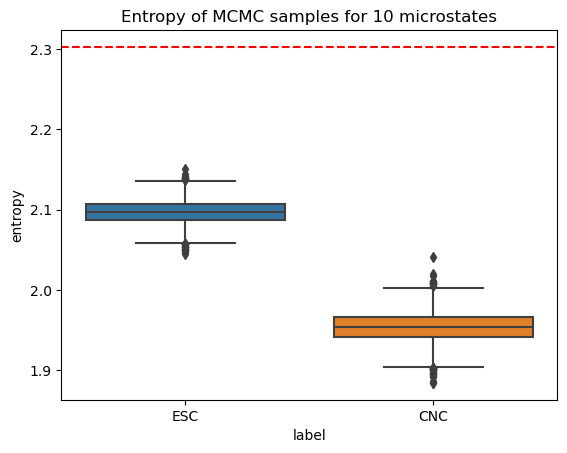

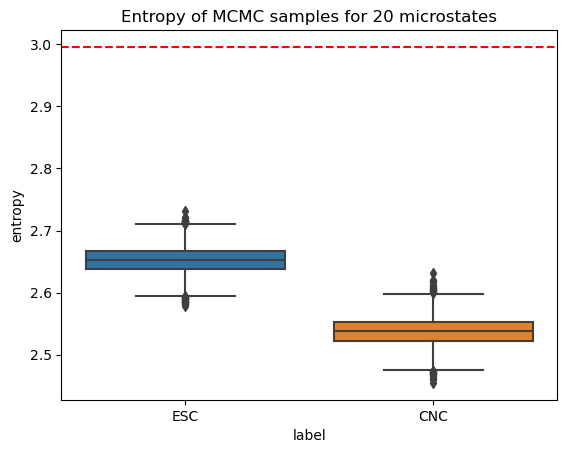

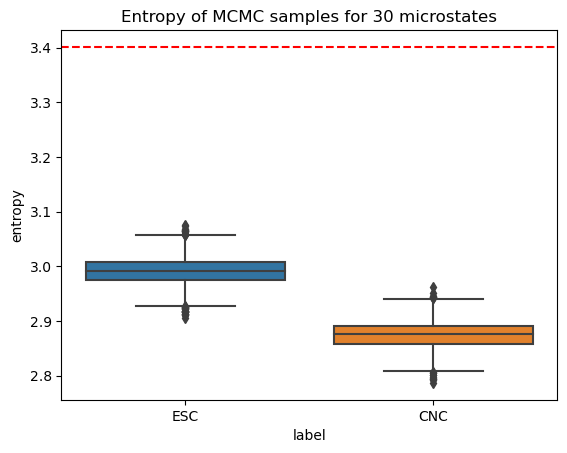

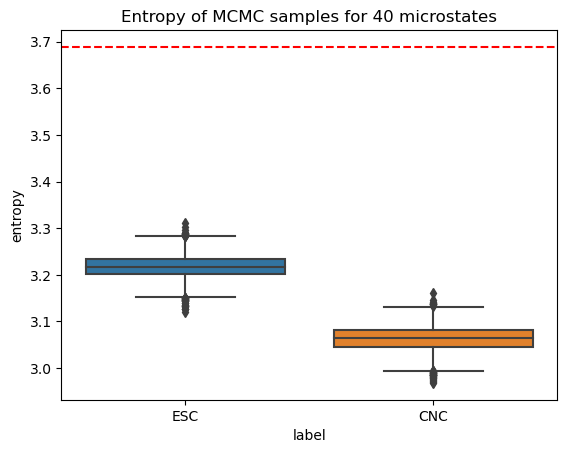

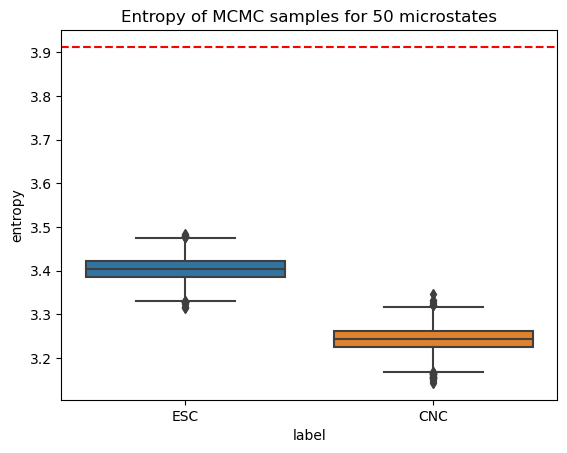

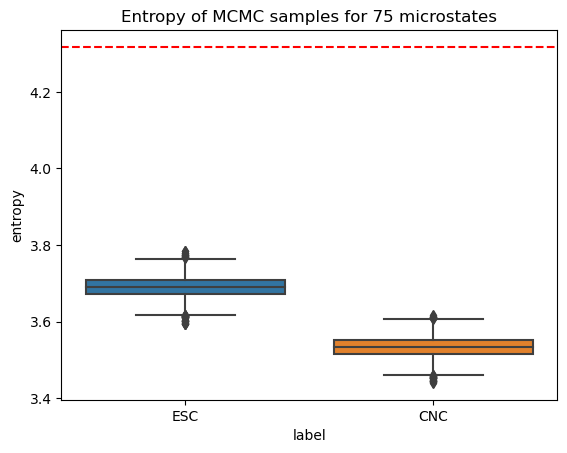

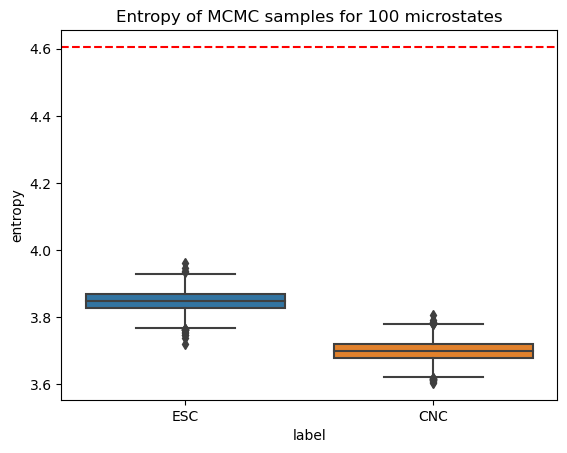

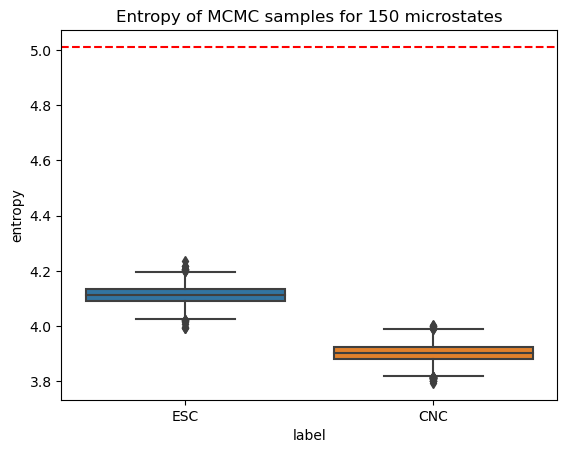

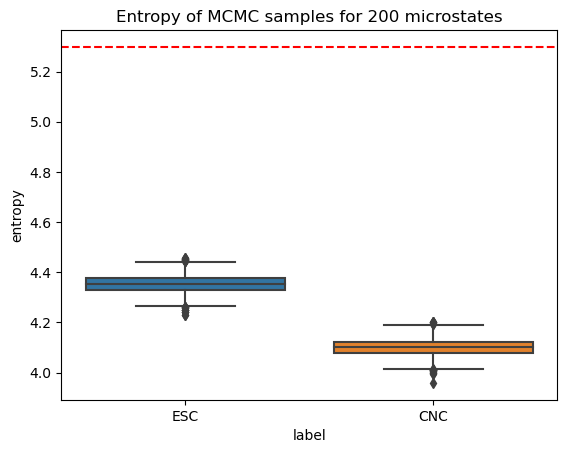

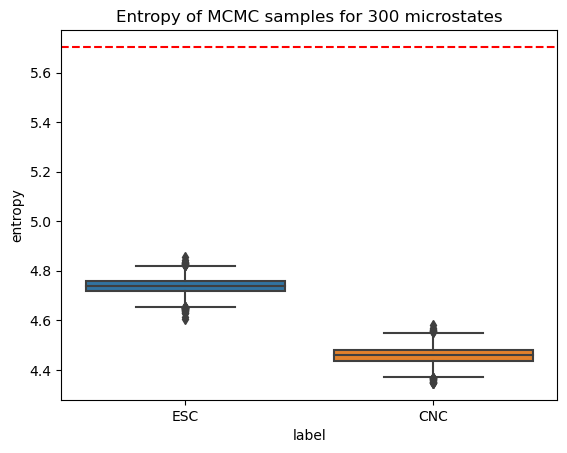

In [120]:
for i, entropy_df in enumerate(entropy_dfs):
    sns.boxplot(data=entropy_df, x='label', y='entropy')
    # plot horizontal lines at y = log(k)
    plt.axhline(y=np.log(num_clusters[i]), color='r', linestyle='--')
    plt.title(f'Entropy of MCMC samples for {num_clusters[i]} microstates')
    plt.savefig(f'{save_dir}/entropy_{num_clusters[i]}_microstates.png')
    plt.show()

In [72]:
pca = PCA(n_components=None)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=[f'PC{i+1}' for i in range(esc_maps_pca.shape[1])])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=[f'PC{i+1}' for i in range(esc_maps_pca.shape[1])])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

In [123]:
# Load parameters for medoids
md_params = []
for f in mcmc_folders:
    # load 'param.pkl' 
    with open(os.path.join(f, 'param.pkl'), 'rb') as file:
        param = pickle.load(file)
        md_params.append(param)


In [40]:
mcmc_weights_esc[0].shape

(4000, 10)

In [124]:
md_microstates = []
for md in md_params:
    md_microstates.append(md['microstates'])


In [ ]:
# Plot the distance maps of these medoids
for md in md_microstates:
    md_maps = [x.reshape(80, 80) for x in md]
    num_maps = len(md_maps)
    
    fig, axs = plt.subplots(num_maps//10, 10, figsize=(20, 2*num_maps//10))
    for i, ax in enumerate(axs.flat):
        if i < num_maps:
            ax.imshow(md_maps[i], cmap='Reds_r')
            ax.set_title(f'Medoid {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.savefig(f'{save_dir}/medoids_{num_maps}_microstates.png')
    plt.show()

In [125]:
# Project microstates from different condition onto the first two PCs
md_microstates_pca = []
for md in md_microstates:
    md_pca = pca.transform(md)
    md_microstates_pca.append(md_pca)

In [75]:
md_microstates_pca[0].shape

(10, 2982)

In [126]:
# Add these to the dataframe with different labels
md_dfs = []
for i, md in enumerate(md_microstates_pca):
    md_df = pd.DataFrame(md, columns=[f'PC{i+1}' for i in range(md.shape[1])])
    md_df['label'] = 'K-medoid {}'.format(num_clusters[i])
    # Add weights to the dataframe
    md_df['esc_weight'] = mcmc_weights_esc[i].mean(axis=0)
    md_df['cnc_weight'] = mcmc_weights_cnc[i].mean(axis=0)
    md_df['log_weight_ratio'] = np.log(md_df['cnc_weight'] / md_df['esc_weight'])
    md_dfs.append(md_df)

md_df = pd.concat(md_dfs, axis=0)

<Axes: xlabel='PC1', ylabel='PC2'>

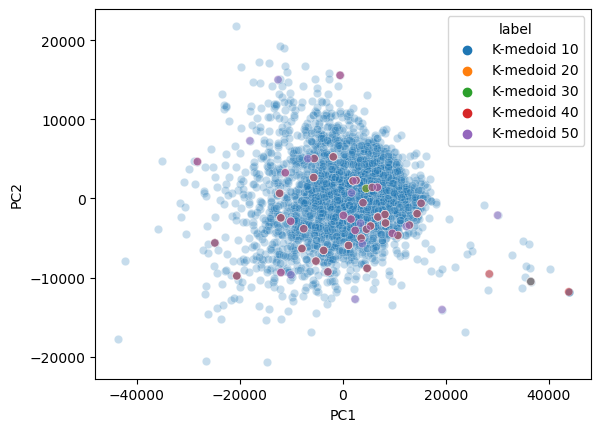

In [16]:
sns.scatterplot(data=all_df, x='PC1', y='PC2', alpha=0.25)
sns.scatterplot(data=md_df, x='PC1', y='PC2', hue='label', alpha=0.5)

In [90]:
md.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

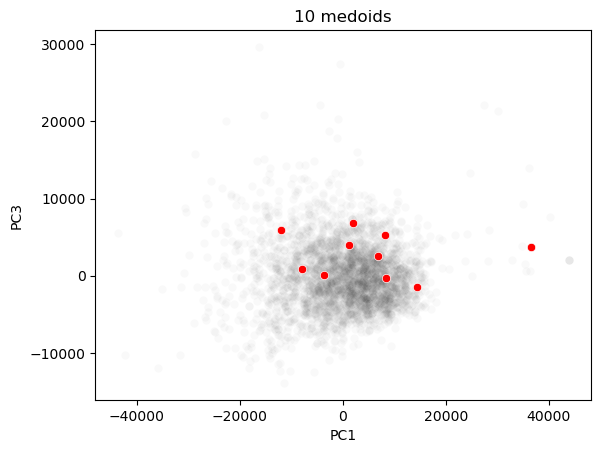

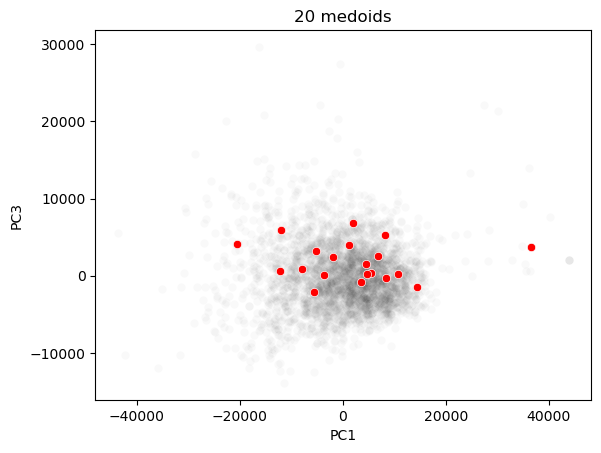

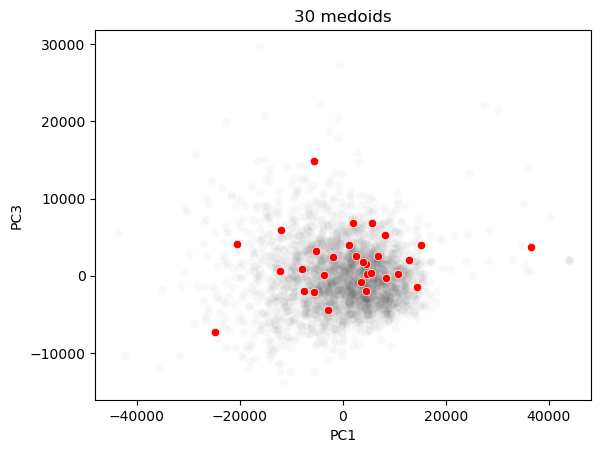

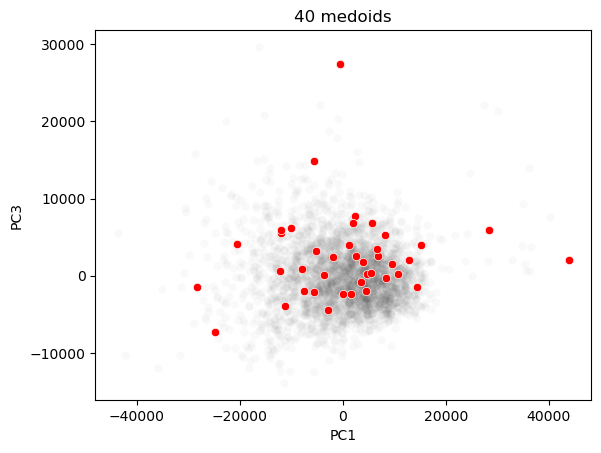

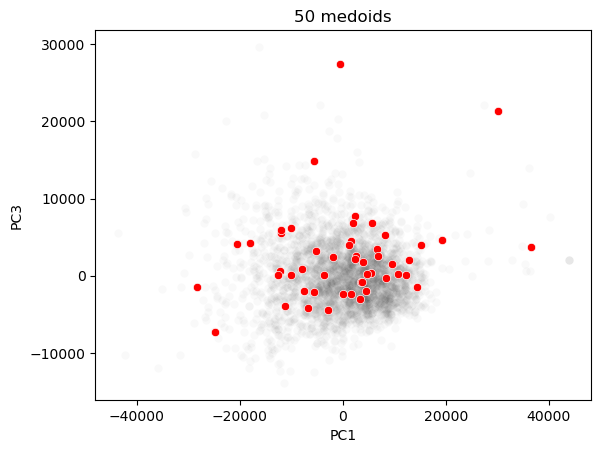

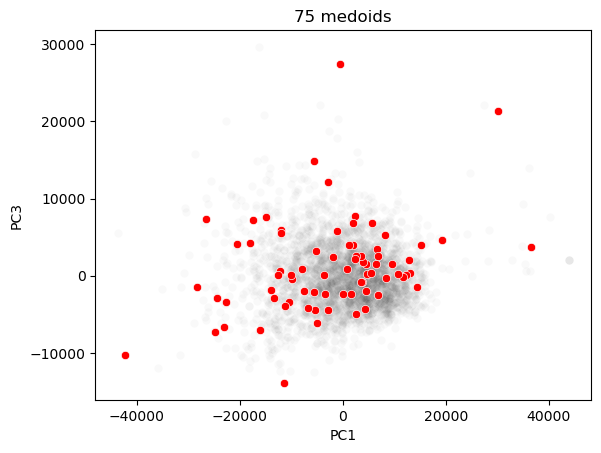

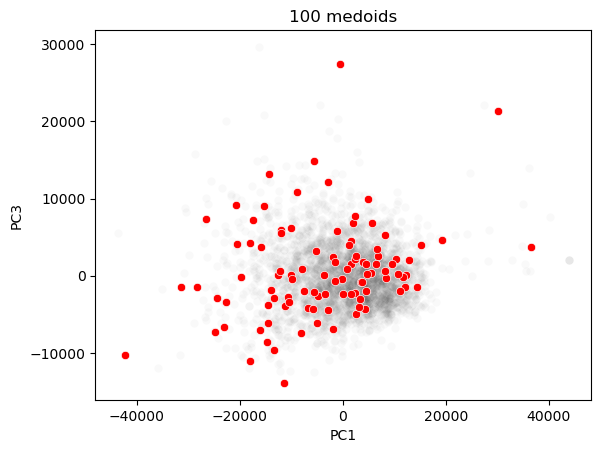

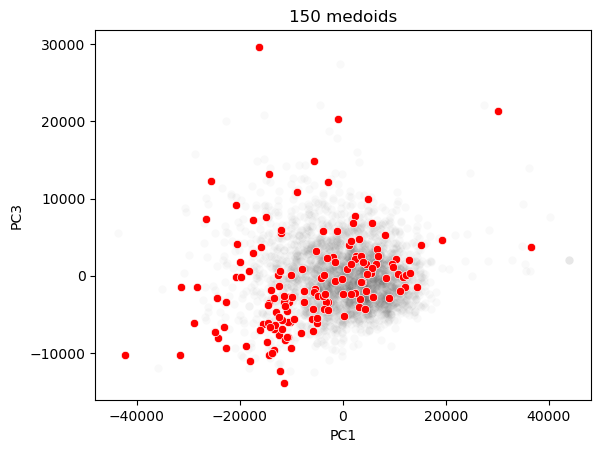

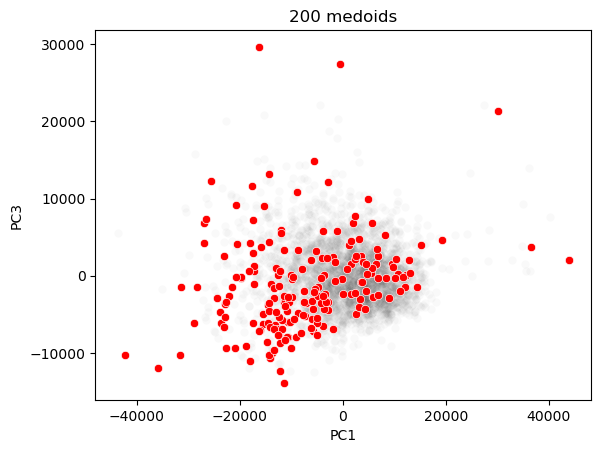

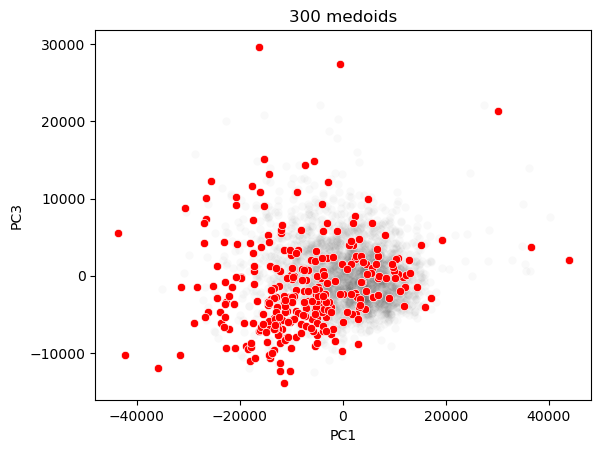

In [142]:
# Plot the location of medoids in different samples on the first two PCs
x_axis = 'PC1'
y_axis = 'PC3'

for i, md in enumerate(md_dfs):
    sns.scatterplot(data=all_df, x=x_axis, y=y_axis, 
                    alpha=0.025, color='black', legend=False)
    sns.scatterplot(data=md, x=x_axis, y=y_axis,
                color='red', legend=False)
    plt.title(f'{num_clusters[i]} medoids')
    plt.savefig(f'{save_dir}/medoids_{num_clusters[i]}_microstates_{x_axis}_{y_axis}.png')
    plt.show()
    
   

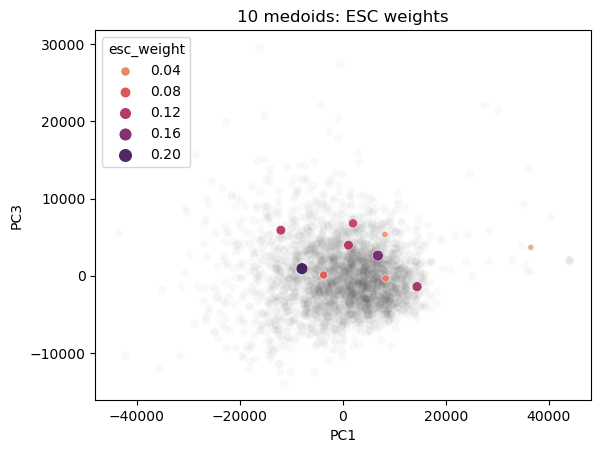

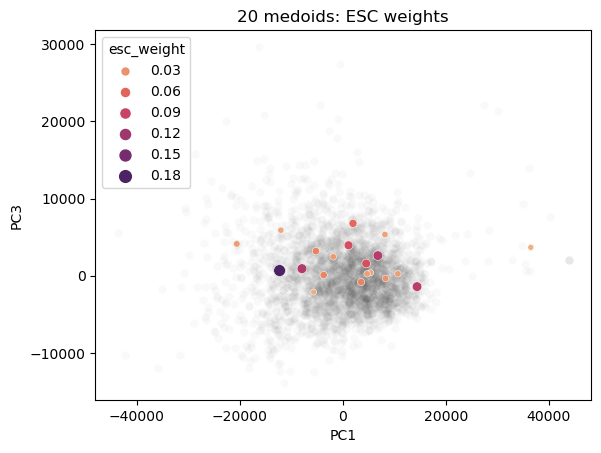

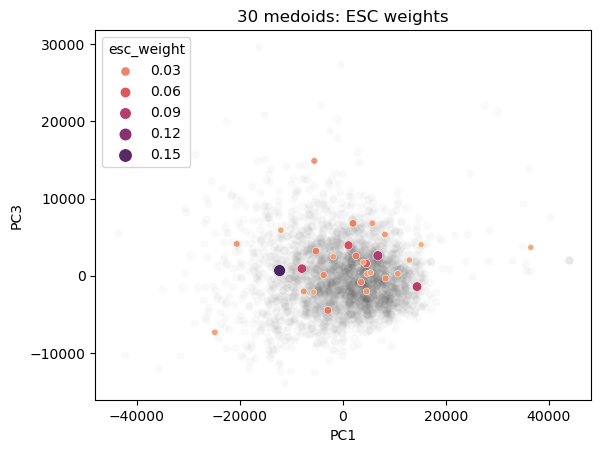

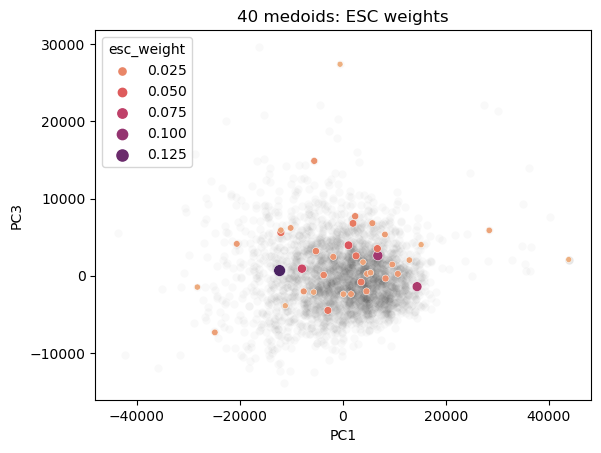

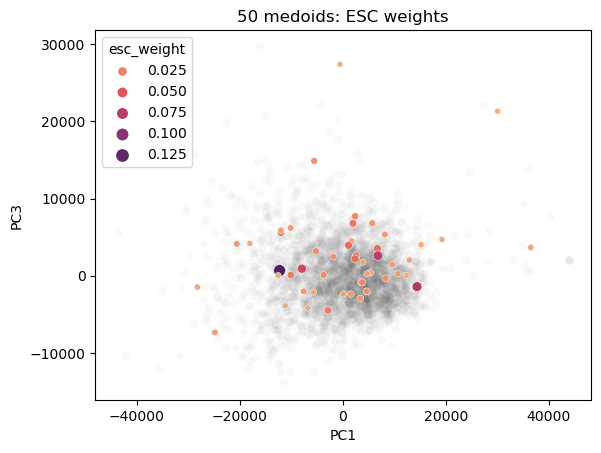

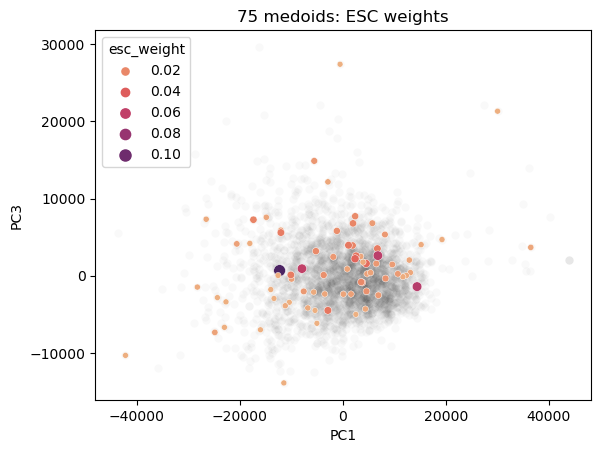

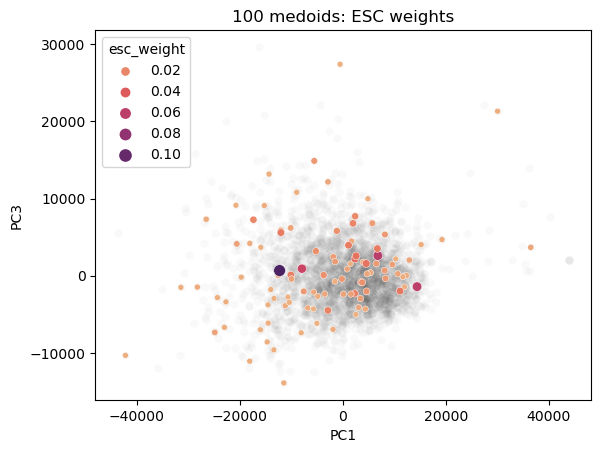

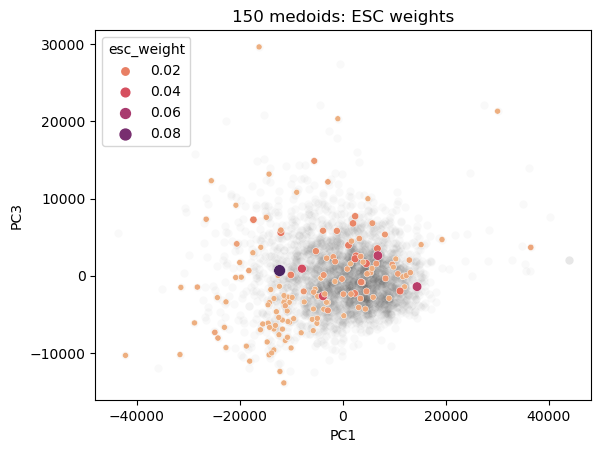

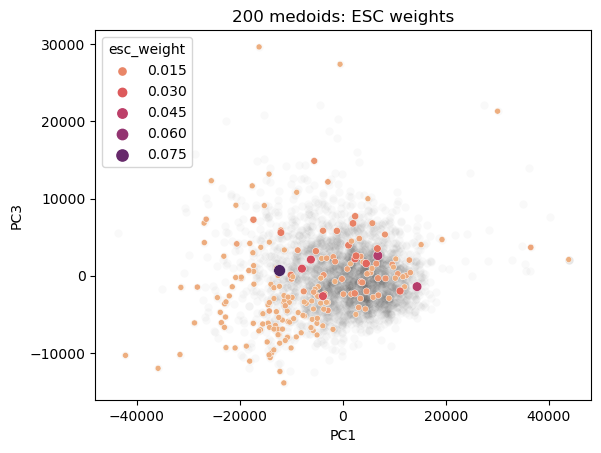

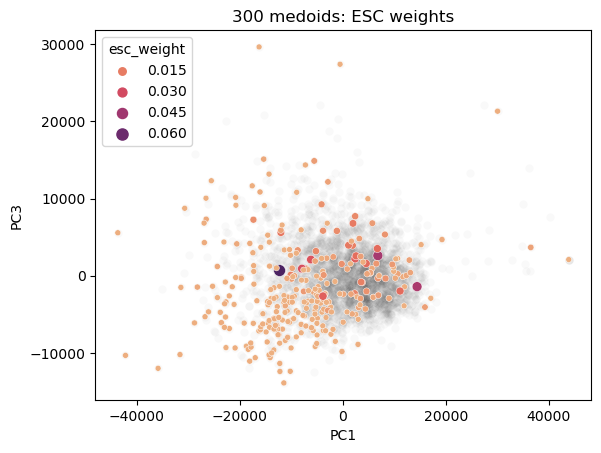

In [143]:
for i, md in enumerate(md_dfs):
    sns.scatterplot(data=all_df, x=x_axis, y=y_axis, 
                    alpha=0.025, color='black', legend=False)
    sns.scatterplot(data=md, x=x_axis, y=y_axis,
                hue='esc_weight', size='esc_weight', palette='flare')
    plt.title(f'{num_clusters[i]} medoids: ESC weights')
    plt.savefig(f'{save_dir}/medoids_{num_clusters[i]}_microstates_{x_axis}_{y_axis}_esc_weights.png')
    plt.show()

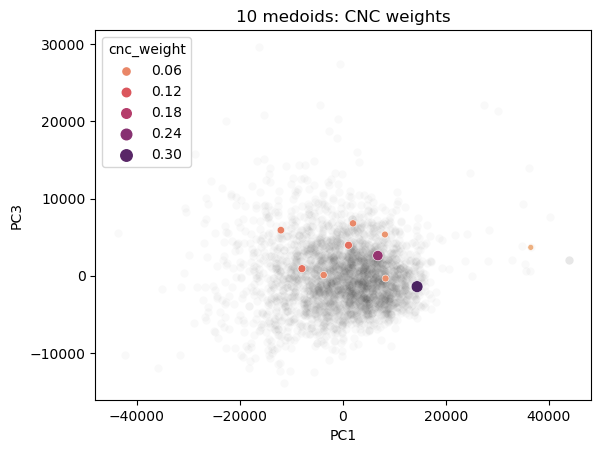

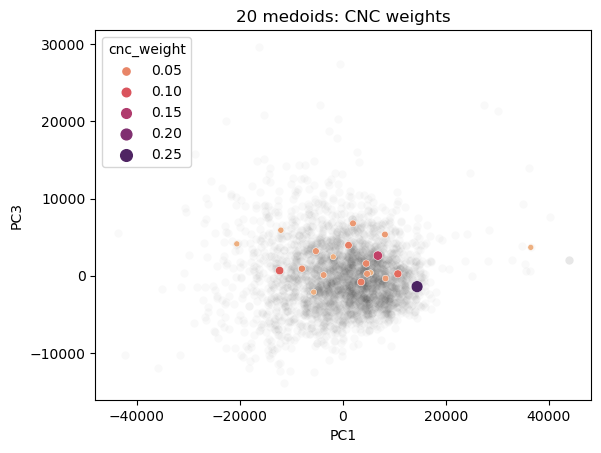

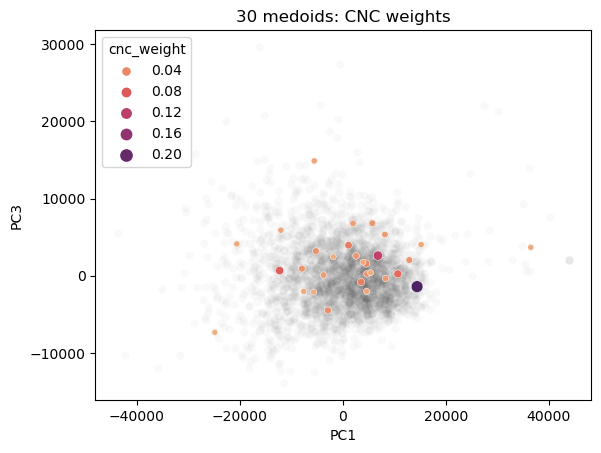

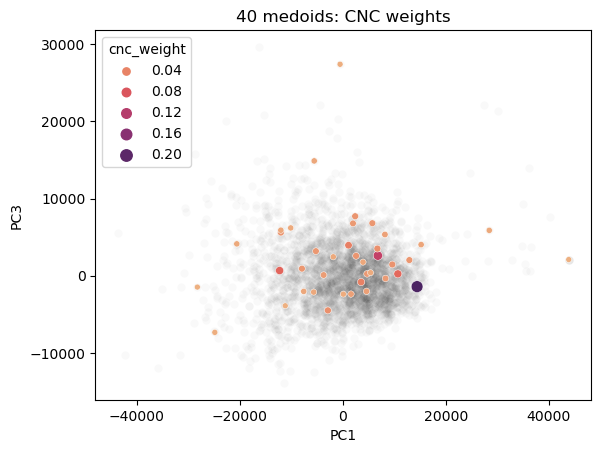

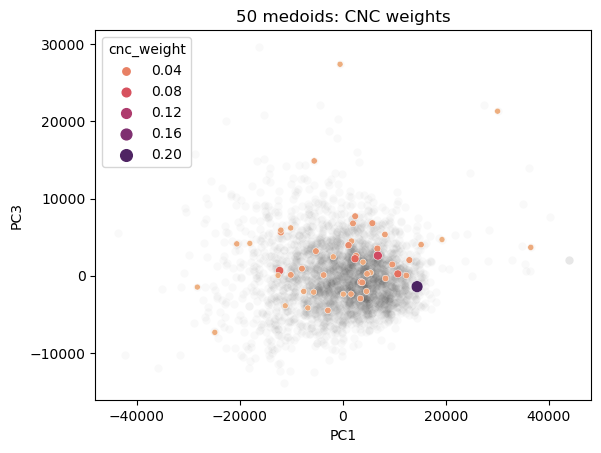

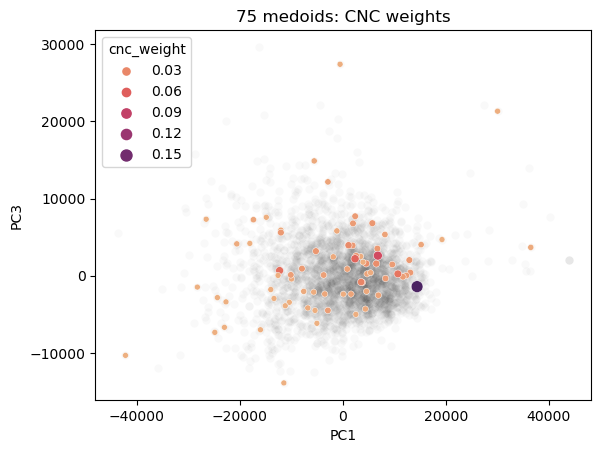

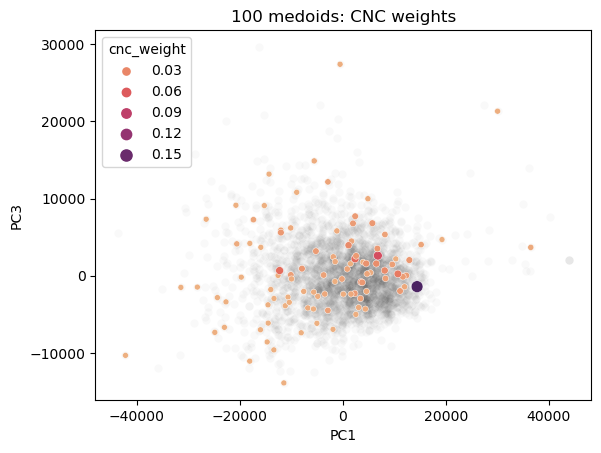

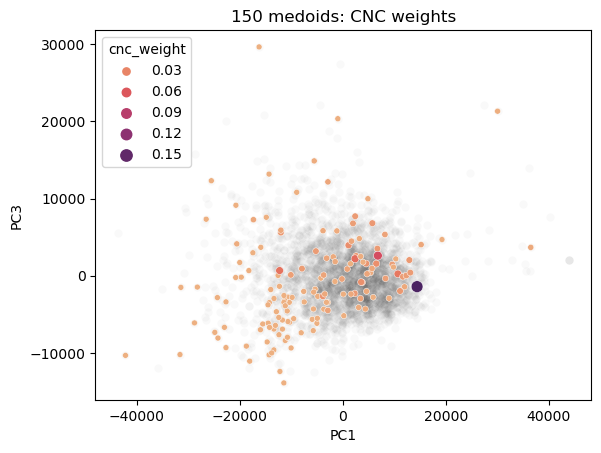

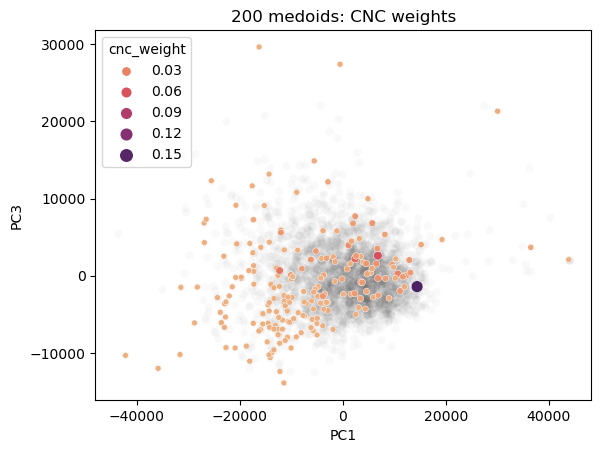

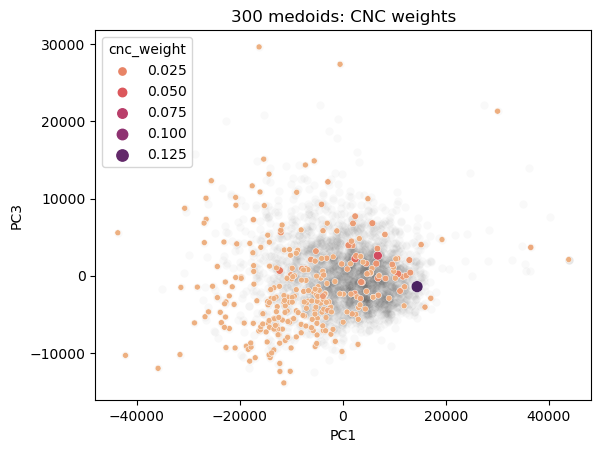

In [144]:
for i, md in enumerate(md_dfs):
    sns.scatterplot(data=all_df, x=x_axis, y=y_axis, 
                    alpha=0.025, color='black', legend=False)
    sns.scatterplot(data=md, x=x_axis, y=y_axis,
                hue='cnc_weight', size='cnc_weight', palette='flare')
    plt.title(f'{num_clusters[i]} medoids: CNC weights')
    plt.savefig(f'{save_dir}/medoids_{num_clusters[i]}_microstates_{x_axis}_{y_axis}_cnc_weights.png')
    plt.show()

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


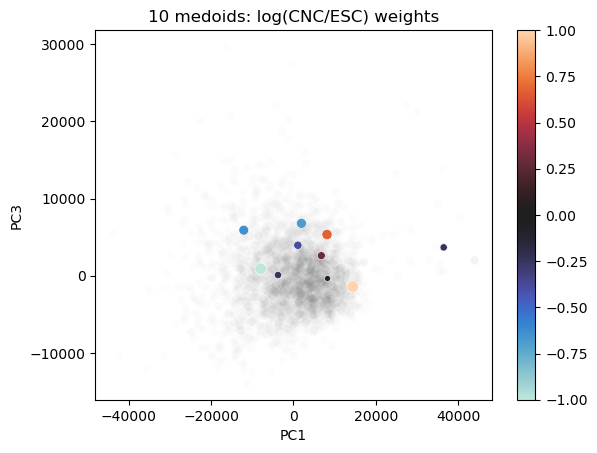

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


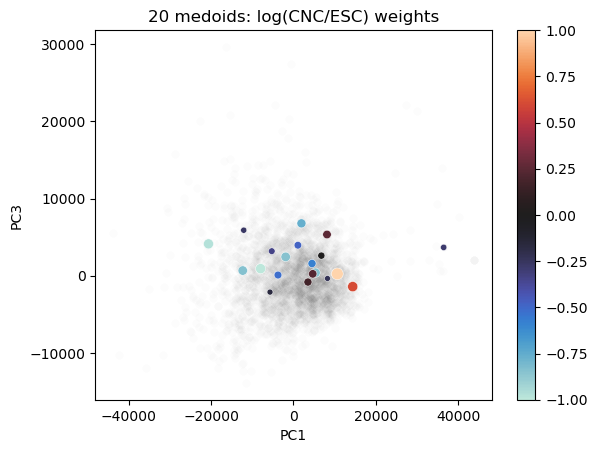

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


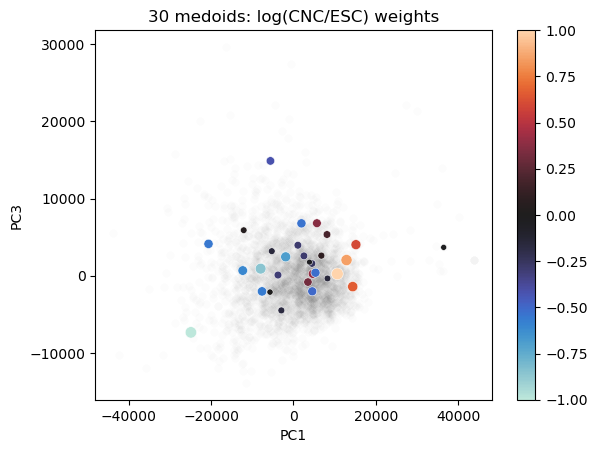

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


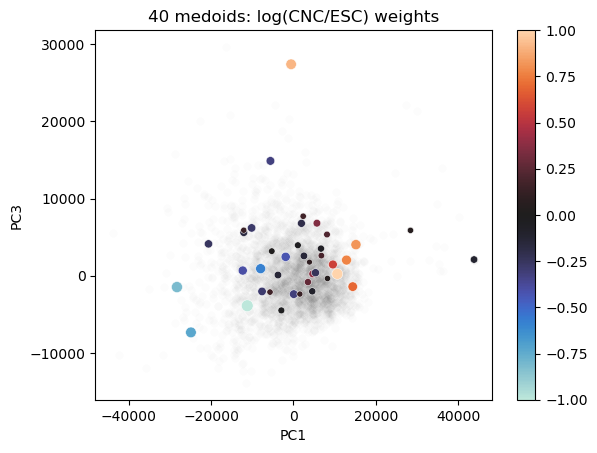

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


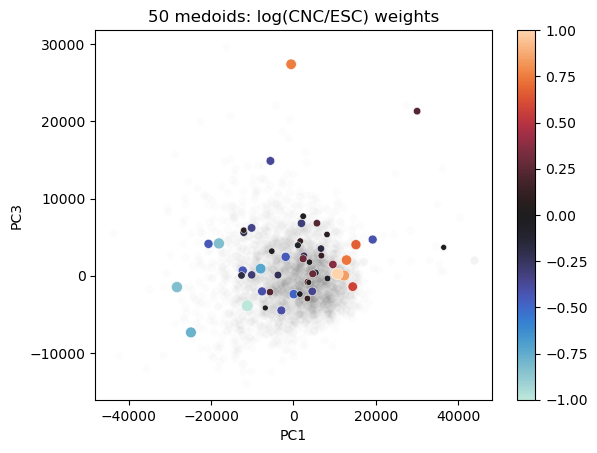

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


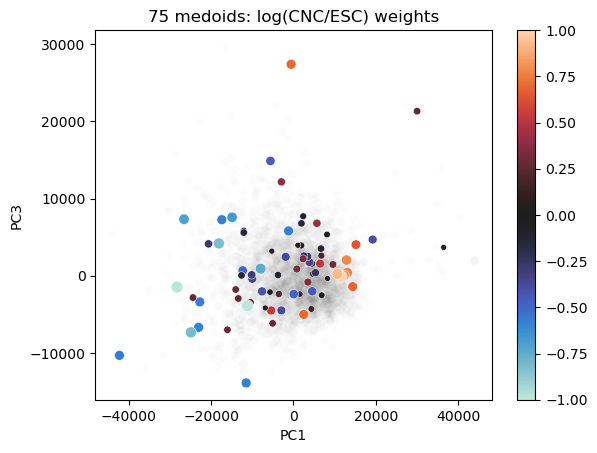

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


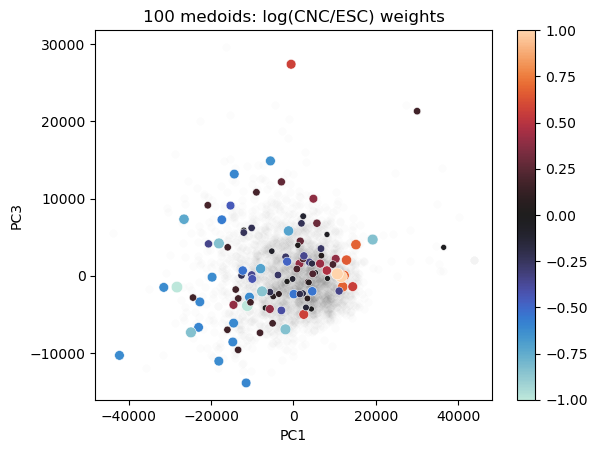

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


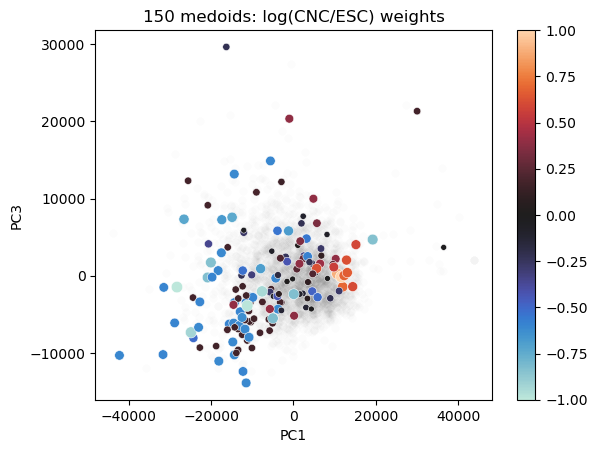

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


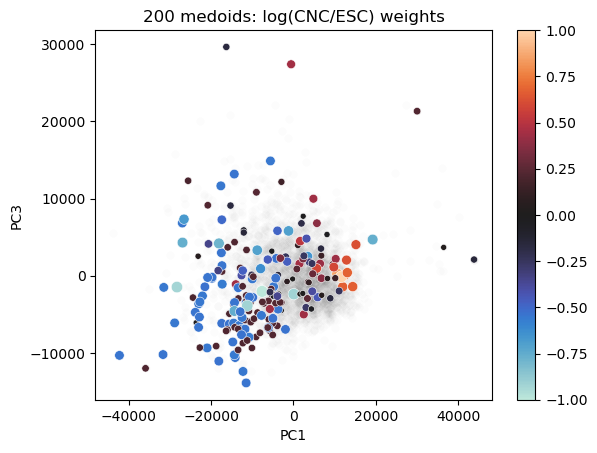

/tmp/ipykernel_121700/3118171220.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


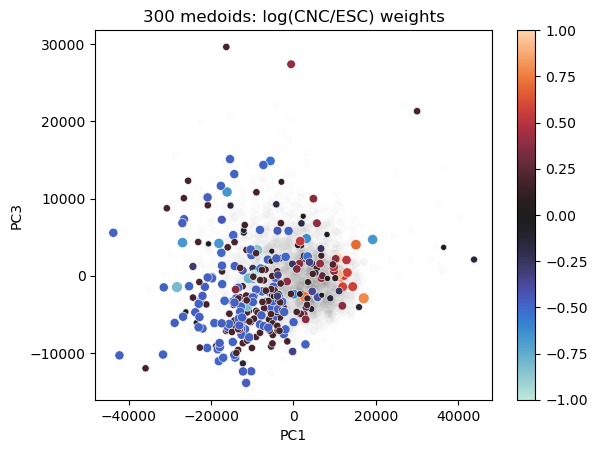

In [145]:
for i, md in enumerate(md_dfs):
     # Add colorbar
     norm = plt.Normalize(-1,  1)
     sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)
     sm.set_array([])
     plt.colorbar(sm)
     
     sns.scatterplot(data=all_df, x=x_axis, y=y_axis, 
                         alpha=0.01, color='black', legend=False)
     sns.scatterplot(data=md, x=x_axis, y=y_axis,
                    hue='log_weight_ratio', palette='icefire', size=np.abs(md['log_weight_ratio']), 
                    norm=norm, legend=False)
     
     plt.title(f'{num_clusters[i]} medoids: log(CNC/ESC) weights')
     plt.savefig(f'{save_dir}/medoids_{num_clusters[i]}_microstates_{x_axis}_{y_axis}_log_weight_ratio.png')
     plt.show()